# Overview #

The purpose of this project is to examine how A/B and hypothesis testing can give better insight into how companies can better understand what could enhance activity on their websites.  The overall goal being a company can convert prospective customers into actual customers.  

The dataset comes from Amir Motefaker on Kaggle: https://www.kaggle.com/datasets/amirmotefaker/ab-testing-dataset/data?select=test_group.csv 


Below are all the features in the dataset:


* Campaign Name: The name of the campaign
* Date: Date of the record
* Spend: Amount spent on the campaign in dollars
* Number of Impressions: Number of impressions the ad crossed through the campaign
* Reach: The number of unique impressions received in the ad
* Number of Website Clicks: Number of website clicks received through the ads
* Number of Searches: Number of users who performed searches on the website
* Number of View Content: Number of users who viewed content and products on the website
* Number of Add to Cart: Number of users who added products to the cart
* Number of Purchase: Number of purchases


There are a Control Campaign and Test Campaign that were uploaded in order to conduct the actual testing.  

An EDA will be conducted, necessary features will be created, and then the hypothesis testing will be done before drawing any conclusions.

## Library and Data Upload ##

In [1]:
# Visualization and Stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tabulate import tabulate

# Pandas and numpy
import pandas as pd
import numpy as np

In [2]:
# Datasets
control = pd.read_csv("/kaggle/input/ab-test-dataset/control_group.csv",delimiter=";")
test = pd.read_csv("/kaggle/input/ab-test-dataset/test_group.csv",delimiter=";")

# Examine datasets
control.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


## EDA ##

In [4]:
# start by looking for any missing values 
control.isna().sum()


Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64

I wanted to fill in the few missing values by using the average but unfortunatley that introduced an error and not all values can use an average value.  

So instead I just used the previous days value which is fine since it's only 1 day.  

In [5]:
# replace with the previous day's value
control = control.fillna(method="bfill")


/tmp/ipykernel_31/633706352.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  control = control.fillna(method="bfill")


In [6]:
# testing values
test.isna().sum()

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       0
Reach                  0
# of Website Clicks    0
# of Searches          0
# of View Content      0
# of Add to Cart       0
# of Purchase          0
dtype: int64

I am going to rename each dataset column in order to make things easier

In [7]:
# control data renaming
new_names = ['Campaign Name', 'Date', 'Spend', 'Impressions', 'Reach',
             'Website Clicks', 'Searches', 'View Content',
             'Add to Cart', 'Purchase']

control.columns = [col + "_control" if col != "Date" else col for col in new_names]

control.head()

,Campaign Name_control,Date,Spend_control,Impressions_control,Reach_control,Website Clicks_control,Searches_control,View Content_control,Add to Cart_control,Purchase_control
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,109076.0,87998.0,4028.0,1709.0,1249.0,784.0,764.0


In [12]:
# test data renaming
new_names = ['Campaign Name', 'Date', 'Spend', 'Impressions', 'Reach',
             'Website Clicks', 'Searches', 'View Content',
             'Add to Cart', 'Purchase']

test.columns = [col + "_test" if col != "Date" else col for col in new_names]

test.head()


,Campaign Name_test,Date,Spend_test,Impressions_test,Reach_test,Website Clicks_test,Searches_test,View Content_test,Add to Cart_test,Purchase_test
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


Next, in order to conduct the necessary testing both datasets need to be put together.

In [13]:
# combine both sets of data
data = df = control.merge(test,how="inner",on="Date")
data.head()

,Campaign Name_control,Date,Spend_control,Impressions_control,Reach_control,Website Clicks_control,Searches_control,View Content_control,Add to Cart_control,Purchase_control,Campaign Name_test,Spend_test,Impressions_test,Reach_test,Website Clicks_test,Searches_test,View Content_test,Add to Cart_test,Purchase_test
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0,Test Campaign,3008,39550,35820,3038,1946,1069,894,255
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0,Test Campaign,2542,100719,91236,4657,2359,1548,879,677
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0,Test Campaign,2365,70263,45198,7885,2572,2367,1268,578
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0,Test Campaign,2710,78451,25937,4216,2216,1437,566,340
4,Control Campaign,5.08.2019,1835,109076.0,87998.0,4028.0,1709.0,1249.0,784.0,764.0,Test Campaign,2297,114295,95138,5863,2106,858,956,768


This new combined dataset will help going forward.  

In [17]:
#Understand 

control_cols = [col for col in data.columns if col.endswith('_control')]
test_cols = [col for col in data.columns if col.endswith('_test')]

control_summary = data[control_cols].describe()
test_summary = data[test_cols].describe()

print(control_summary)
print(test_summary)

       Spend_control  Impressions_control  Reach_control  \
count      30.000000            30.000000      30.000000   
mean     2288.433333        109543.633333   88816.700000   
std       367.334451         21311.878487   21453.184853   
min      1757.000000         71274.000000   42859.000000   
25%      1945.500000         95191.250000   75300.250000   
50%      2299.500000        112368.000000   91418.000000   
75%      2532.000000        121259.000000  101958.750000   
max      3083.000000        145248.000000  127852.000000   

       Website Clicks_control  Searches_control  View Content_control  \
count               30.000000         30.000000             30.000000   
mean              5277.700000       2204.233333           1920.633333   
std               1742.860177        856.150474            774.480938   
min               2277.000000       1001.000000            848.000000   
25%               4042.250000       1629.250000           1249.000000   
50%               508

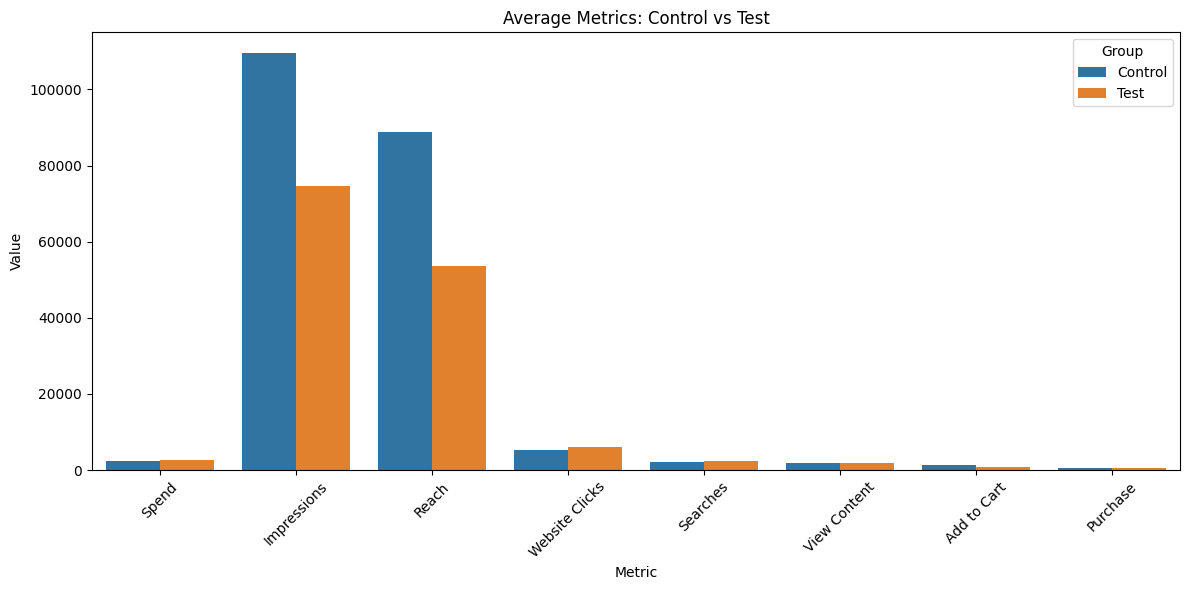

In [19]:
# Filter out non-numeric control/test columns
control_numeric = data[control_cols].select_dtypes(include='number')
test_numeric = data[test_cols].select_dtypes(include='number')

# Compute mean values
control_means = control_numeric.mean()
test_means = test_numeric.mean()

# Strip suffixes and prepare DataFrame
metrics = [col.replace('_control', '') for col in control_numeric.columns]
mean_df = pd.DataFrame({
    'Metric': metrics,
    'Control': control_means.values,
    'Test': test_means.values
})

# Melt for seaborn barplot
mean_df_melted = mean_df.melt(id_vars='Metric', var_name='Group', value_name='Value')

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=mean_df_melted, x='Metric', y='Value', hue='Group')
plt.title('Average Metrics: Control vs Test')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on these average values there are a few important takeaways:

* Most of the metrics, on average, are pretty close between the control and testing groups except for "Impressions" and "Reach" where there is a bit more of a gap.
* Even with that gap we can still put together a few metrics that will give us a better idea of how to conduct our hypothesis testing

These key performance metrics (KPM) for each group are as follows:


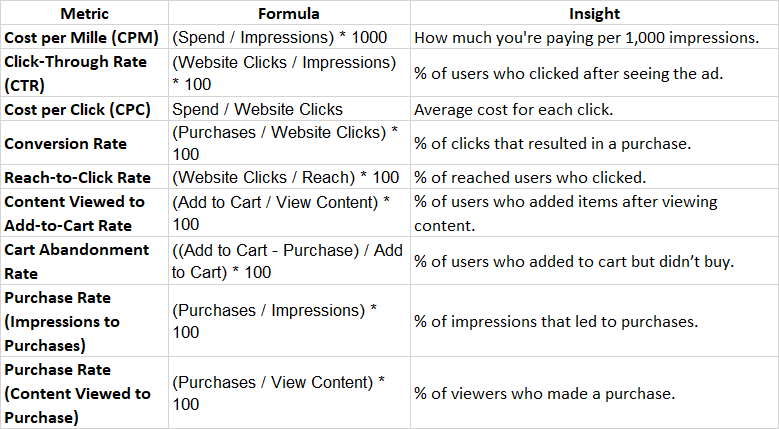
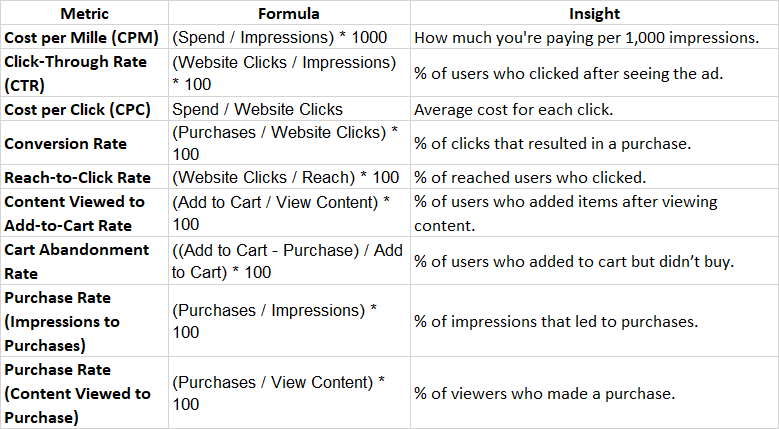
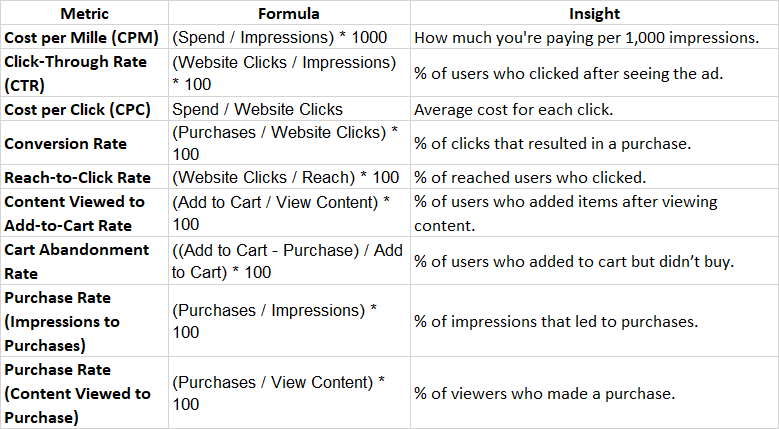
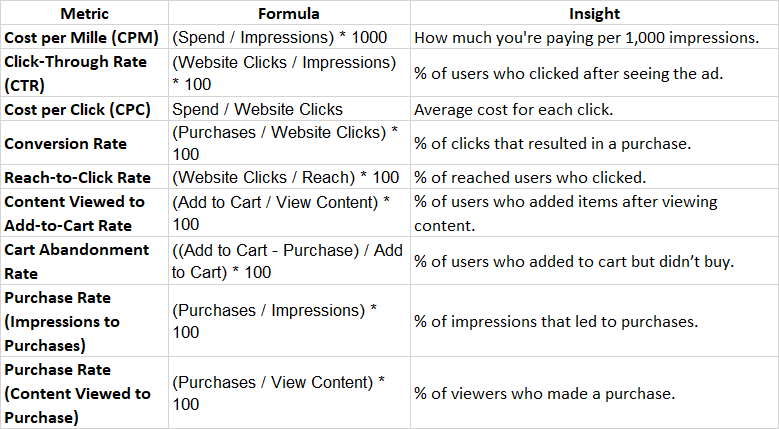

In [20]:


# Cost per Mille (CPM)
data['Cost per Mille (CPM)_control'] = np.divide(data['Spend_control'], data['Impressions_control']) * 1000
data['Cost per Mille (CPM)_test'] = np.divide(data['Spend_test'], data['Impressions_test']) * 1000

# Click-Through Rate (CTR)
data['Click-Through Rate (CTR)_control'] = np.divide(data['Website Clicks_control'], data['Impressions_control']) * 100
data['Click-Through Rate (CTR)_test'] = np.divide(data['Website Clicks_test'], data['Impressions_test']) * 100

# Cost per Click (CPC)
data['Cost per Click (CPC)_control'] = np.divide(data['Spend_control'], data['Website Clicks_control'])
data['Cost per Click (CPC)_test'] = np.divide(data['Spend_test'], data['Website Clicks_test'])

# Conversion Rate
data['Conversion Rate_control'] = np.divide(data['Purchase_control'], data['Website Clicks_control']) * 100
data['Conversion Rate_test'] = np.divide(data['Purchase_test'], data['Website Clicks_test']) * 100

# Reach-to-Click Rate
data['Reach-to-Click Rate_control'] = np.divide(data['Website Clicks_control'], data['Reach_control']) * 100
data['Reach-to-Click Rate_test'] = np.divide(data['Website Clicks_test'], data['Reach_test']) * 100

# Content Viewed-to-Add-to-Cart Rate
data['Content Viewed-to-Add-to-Cart Rate_control'] = np.divide(data['Add to Cart_control'], data['View Content_control']) * 100
data['Content Viewed-to-Add-to-Cart Rate_test'] = np.divide(data['Add to Cart_test'], data['View Content_test']) * 100

# Cart Abandonment Rate
data['Cart Abandonment Rate_control'] = np.divide(
    (data['Add to Cart_control'] - data['Purchase_control']), data['Add to Cart_control']
) * 100
data['Cart Abandonment Rate_test'] = np.divide(
    (data['Add to Cart_test'] - data['Purchase_test']), data['Add to Cart_test']
) * 100

# Purchase Rate (Impressions to Purchases)
data['Purchase Rate (Impressions to Purchases)_control'] = np.divide(data['Purchase_control'], data['Impressions_control']) * 100
data['Purchase Rate (Impressions to Purchases)_test'] = np.divide(data['Purchase_test'], data['Impressions_test']) * 100

# Purchase Rate (Content Viewed to Purchase)
data['Purchase Rate (Content Viewed to Purchase)_control'] = np.divide(data['Purchase_control'], data['View Content_control']) * 100
data['Purchase Rate (Content Viewed to Purchase)_test'] = np.divide(data['Purchase_test'], data['View Content_test']) * 100


## Hypothesis Testing ##


In [22]:
features = ["Cost per Mille (CPM)","Click-Through Rate (CTR)","Cost per Click (CPC)","Conversion Rate","Reach-to-Click Rate",
           "Content Viewed-to-Add-to-Cart Rate","Cart Abandonment Rate","Purchase Rate (Impressions to Purchases)",
            "Purchase Rate (Content Viewed to Purchase)"]

Overall the hypothesis test will look like this:

**H0:** There is no statistical significant changes between the control and test group

**H0:** There are statistically significant changes between the control and test group




One important note, it is likely that each feature has a different type of distribution.  So, depending on the distribution there's going to be a different approach.  

If the data is normally distributed and has similar variance, an independent T test will work.

If the data is normally distributed but doesn't have similar variance, a Welch's t-test will work.

If the data is not normally distributed, a Mann-Whitney U test will work.  

In [23]:
from scipy.stats import shapiro, levene, ttest_ind, ttest_ind_from_stats, mannwhitneyu

for feature in features:
    control_feat = f"{feature}_control"
    test_feat = f"{feature}_test"
    
    control_data = data[control_feat].dropna()
    test_data = data[test_feat].dropna()

    # Step 1: Normality Test (Shapiro-Wilk)
    _, p_control_norm = shapiro(control_data)
    _, p_test_norm = shapiro(test_data)
    
    control_normal = p_control_norm > 0.05
    test_normal = p_test_norm > 0.05
    
    if not (control_normal and test_normal):
        test_type = "Mann-Whitney U test (non-parametric)"
    else:
        # Step 2: Variance Equality Test
        _, p_var = levene(control_data, test_data)
        if p_var > 0.05:
            test_type = "Independent T-test (equal variances)"
        else:
            test_type = "Welch’s T-test (unequal variances)"
    
    print(f"{feature}: {test_type}")


Cost per Mille (CPM): Mann-Whitney U test (non-parametric)
Click-Through Rate (CTR): Mann-Whitney U test (non-parametric)
Cost per Click (CPC): Mann-Whitney U test (non-parametric)
Conversion Rate: Mann-Whitney U test (non-parametric)
Reach-to-Click Rate: Mann-Whitney U test (non-parametric)
Content Viewed-to-Add-to-Cart Rate: Mann-Whitney U test (non-parametric)
Cart Abandonment Rate: Mann-Whitney U test (non-parametric)
Purchase Rate (Impressions to Purchases): Mann-Whitney U test (non-parametric)
Purchase Rate (Content Viewed to Purchase): Mann-Whitney U test (non-parametric)


Looks like it will all be Mann Whitney

In [24]:

alpha = 0.05  # significance level

for feature in features:
    control_col = f"{feature}_control"
    test_col = f"{feature}_test"

    control_data = data[control_col].dropna()
    test_data = data[test_col].dropna()

    stat, p_value = mannwhitneyu(control_data, test_data, alternative='two-sided')  # use 'greater' or 'less' if you have a directional hypothesis

    if p_value < alpha:
        result = "Reject H₀ — significant difference"
    else:
        result = "Fail to reject H₀ — no significant difference"

    print(f"{feature}:\n  U-statistic = {stat:.2f}, p-value = {p_value:.4f} → {result}\n")


Cost per Mille (CPM):
  U-statistic = 115.00, p-value = 0.0000 → Reject H₀ — significant difference

Click-Through Rate (CTR):
  U-statistic = 195.00, p-value = 0.0002 → Reject H₀ — significant difference

Cost per Click (CPC):
  U-statistic = 468.00, p-value = 0.7958 → Fail to reject H₀ — no significant difference

Conversion Rate:
  U-statistic = 532.00, p-value = 0.2282 → Fail to reject H₀ — no significant difference

Reach-to-Click Rate:
  U-statistic = 171.00, p-value = 0.0000 → Reject H₀ — significant difference

Content Viewed-to-Add-to-Cart Rate:
  U-statistic = 629.00, p-value = 0.0083 → Reject H₀ — significant difference

Cart Abandonment Rate:
  U-statistic = 685.00, p-value = 0.0005 → Reject H₀ — significant difference

Purchase Rate (Impressions to Purchases):
  U-statistic = 261.00, p-value = 0.0053 → Reject H₀ — significant difference

Purchase Rate (Content Viewed to Purchase):
  U-statistic = 475.00, p-value = 0.7172 → Fail to reject H₀ — no significant difference



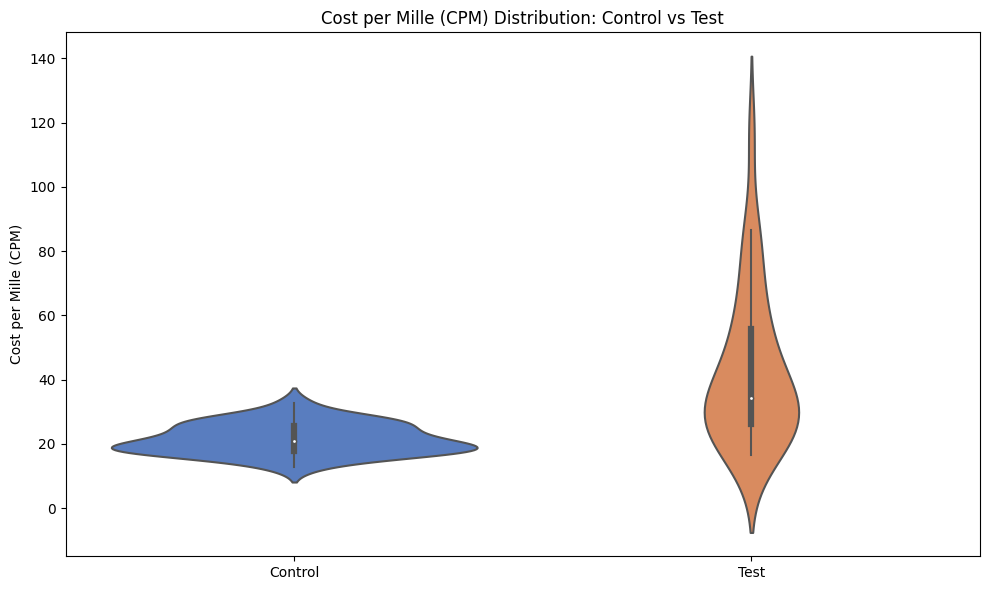

🔍 Summary Statistics for Cost per Mille (CPM)
              mean     median        std        min         max
Control  21.552625  20.880428   4.756058  12.908956   32.553985
Test     42.681041  34.101554  23.749342  16.447177  116.602282

--------------------------------------------------------------------------------



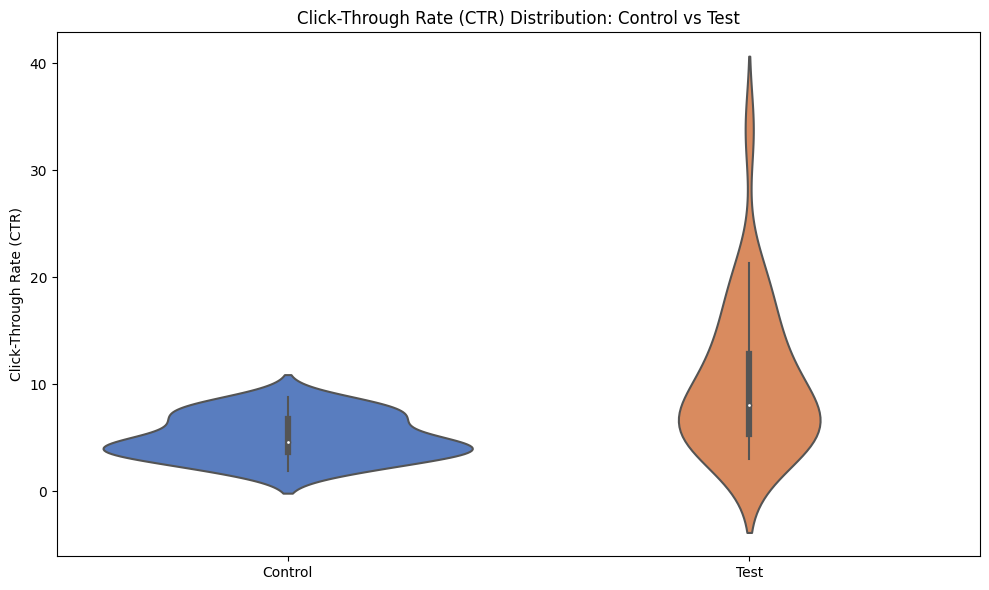

🔍 Summary Statistics for Click-Through Rate (CTR)
              mean    median       std       min        max
Control   5.049103  4.579234  2.031317  1.857546   8.830912
Test     10.242260  8.035887  6.770897  2.982351  33.821766

--------------------------------------------------------------------------------



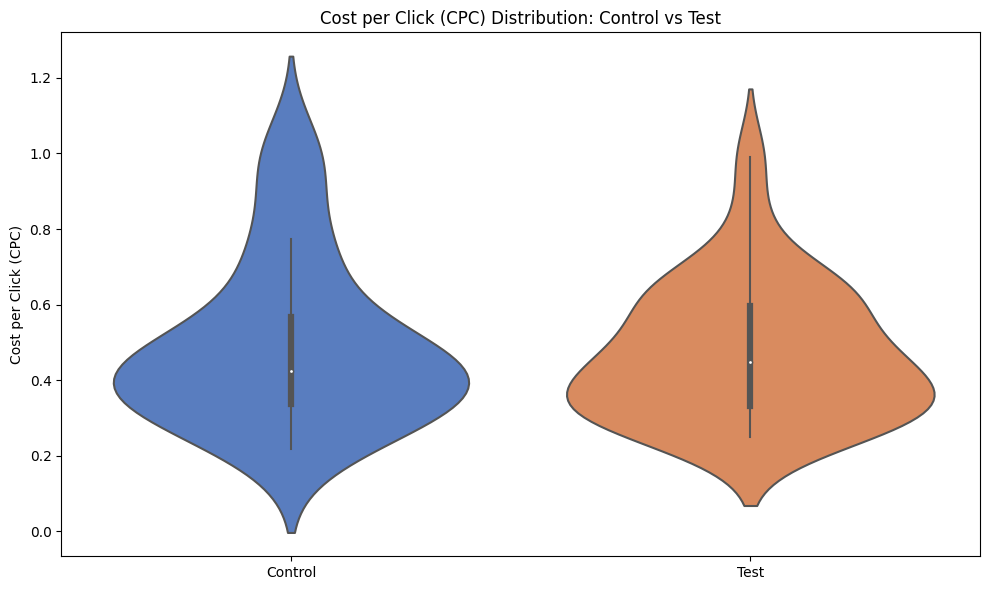

🔍 Summary Statistics for Cost per Click (CPC)
             mean    median       std       min       max
Control  0.493596  0.423306  0.217290  0.216646  1.037626
Test     0.468718  0.448842  0.178566  0.248799  0.990125

--------------------------------------------------------------------------------



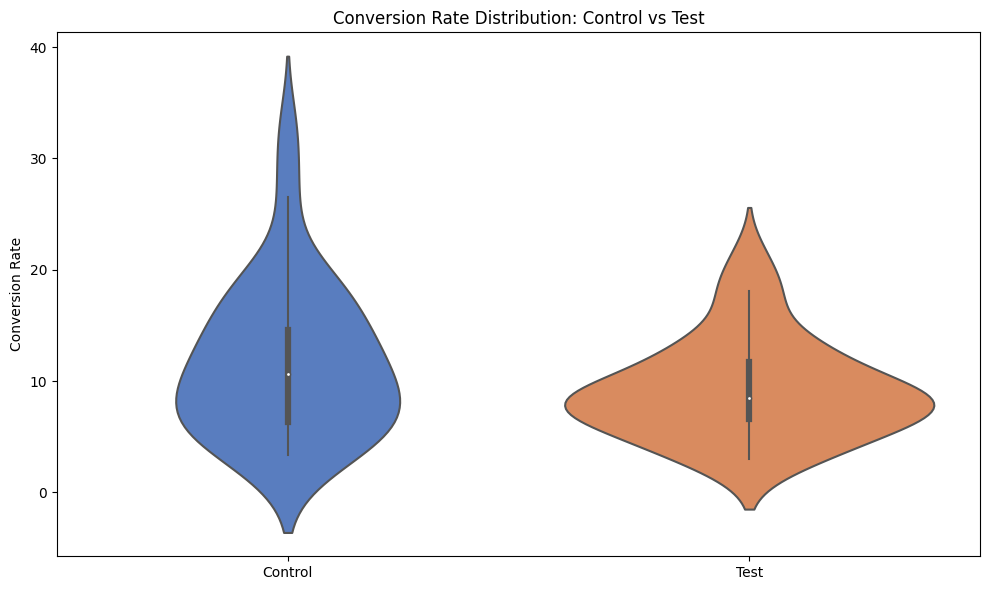

🔍 Summary Statistics for Conversion Rate
              mean     median       std       min        max
Control  11.726871  10.660219  6.857074  3.349427  32.235397
Test      9.231182   8.454291  4.448987  3.008850  21.085051

--------------------------------------------------------------------------------



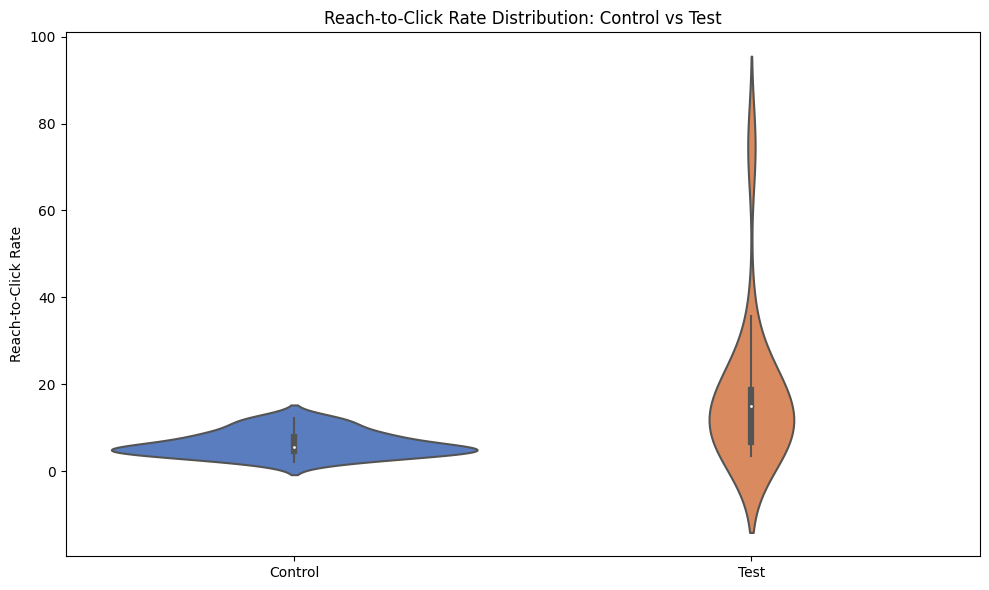

🔍 Summary Statistics for Reach-to-Click Rate
              mean     median        std       min        max
Control   6.386544   5.458460   2.856057  2.064888  12.323907
Test     17.408847  14.911351  17.303012  3.393157  77.976977

--------------------------------------------------------------------------------



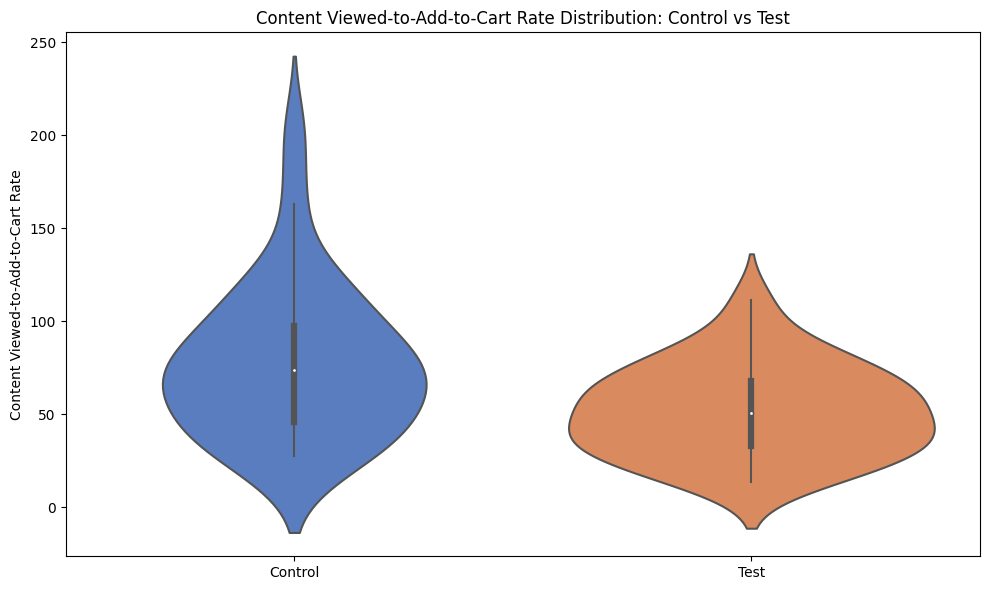

🔍 Summary Statistics for Content Viewed-to-Add-to-Cart Rate
              mean     median        std        min         max
Control  77.284848  73.976828  40.523121  27.409639  201.533019
Test     51.509579  50.853952  24.502629  13.473424  111.421911

--------------------------------------------------------------------------------



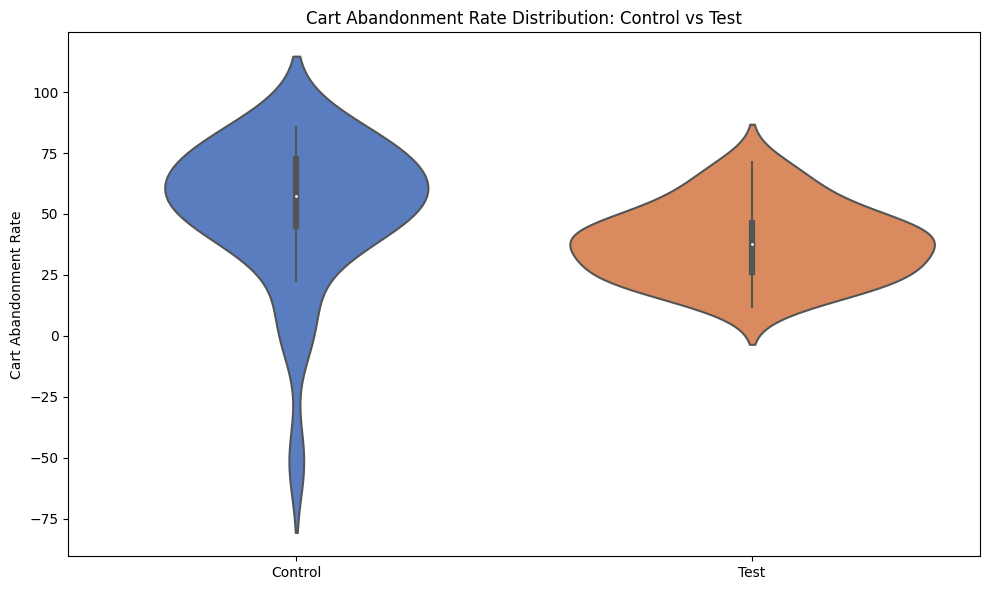

🔍 Summary Statistics for Cart Abandonment Rate
              mean     median        std        min        max
Control  52.557779  57.253117  28.720890 -51.583710  85.663717
Test     38.205134  37.859736  15.146746  11.870504  71.476510

--------------------------------------------------------------------------------



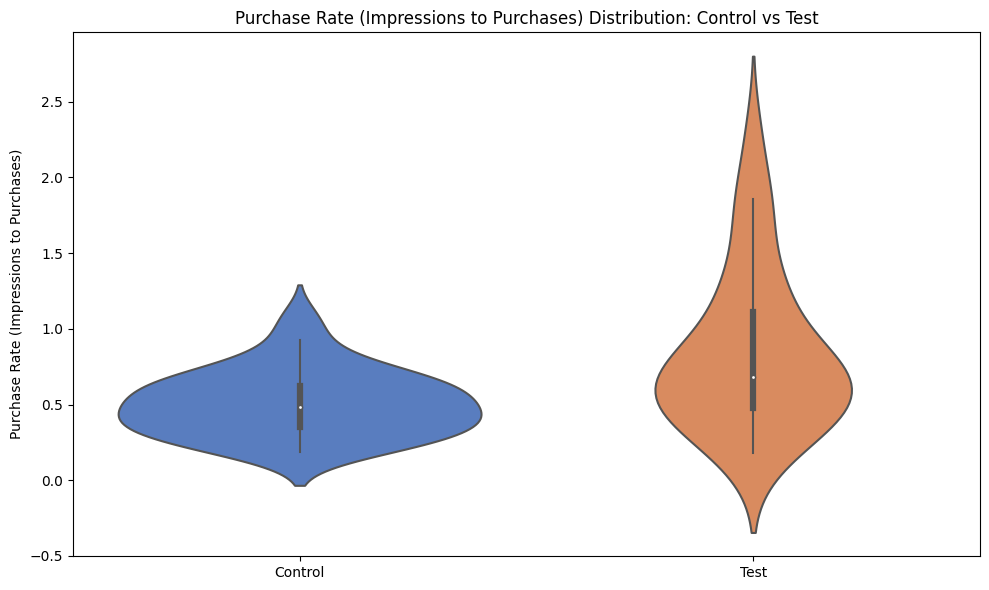

🔍 Summary Statistics for Purchase Rate (Impressions to Purchases)
             mean    median       std       min       max
Control  0.506762  0.484448  0.216495  0.185600  1.071610
Test     0.842521  0.681920  0.521477  0.183149  2.273434

--------------------------------------------------------------------------------



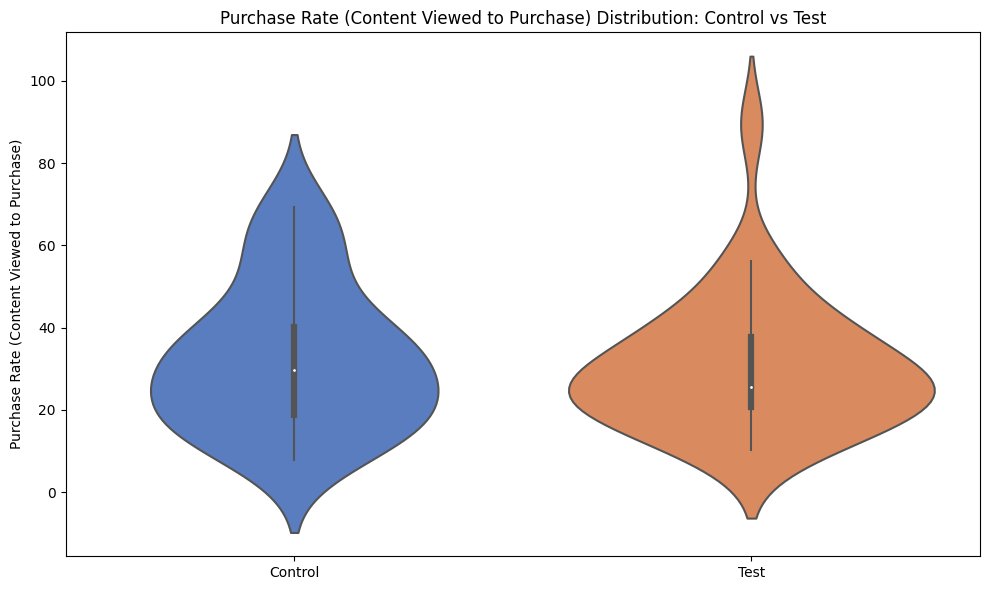

🔍 Summary Statistics for Purchase Rate (Content Viewed to Purchase)
              mean     median        std        min        max
Control  32.461283  29.656733  17.499801   7.916568  69.224063
Test     30.547023  25.522407  16.296312  10.190325  89.510490

--------------------------------------------------------------------------------



In [26]:

# Loop through each feature
for feature in features:
    control_col = f"{feature}_control"
    test_col = f"{feature}_test"

    # Prepare data for plotting
    plot_df = data[[control_col, test_col]].copy()
    plot_df = plot_df.rename(columns={control_col: 'Control', test_col: 'Test'})
    plot_df_melted = plot_df.melt(var_name='Group', value_name='Value')

    # Plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=plot_df_melted, x='Group', y='Value', inner='box', palette='muted')
    plt.title(f'{feature} Distribution: Control vs Test')
    plt.xlabel('')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

    # Summary statistics
    print(f"🔍 Summary Statistics for {feature}")
    print(plot_df.describe().T[['mean', '50%', 'std', 'min', 'max']].rename(columns={"50%": "median"}))
    print("\n" + "-"*80 + "\n")


## Conclusions ##

Based on the results, overall we could say that the test group proved more effective than the control group.  Even though not every feature was able to reject the null hypothesis, most did.  

Overall, this comes down to customers spending money.  You can tell by the purchage rates and click through rates in those categories it's higher in the test group versus the control group.  Not to mention the test group is more cost effective.

However it's still fair to say that each feature isn't quite as good as the others.  In the future, that can be improved upon though by tweaking the test campaign and re-running the tests.  